In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A

# In[2]:


import torch
torch.cuda.set_device(2)

In [2]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_multilabel_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images_labelSmoothing.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    escribir = ""
                    l = l.split(",")
                    for clas in l[1:]:
                        if float(clas)>0:
                            escribir= escribir +str(l.index(clas)-1) +" "
                    escribir = escribir[:-1]
                    if len(escribir)==0:
                        escribir = escribir+ "0"
                    escribir = escribir + "\n"
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l[0]+","+escribir)
#                     print(l)
                

In [3]:
create_csvValid("./dataset_split_38frames/test")

In [4]:
import pandas as pd
import numpy as np

dfValid = pd.read_csv('./dataset_split_38frames/df_multilabel_train.csv')

dfTest = pd.read_csv('./dataset_split_38frames/df_multilabel_test.csv')


# In[5]:


# prueba = dfValid


# prueba = prueba.iloc[np.random.permutation(len(prueba))]
# prueba = prueba[0:int(len(prueba)*0.1)]
# # In[6]:
# # Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# # usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# # dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]




# # Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# # 0.1 posiciones si está se devuelve 
# def is_valid(path):
#     name = path[0]
# #     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
#     return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# # In[13]:

# def get_class(path):
#     name = path[0]
#     return (dfValid[dfValid['images']==name])['class']


In [5]:
dfValid.head()

,images,class
0,IDU001V001/images/IDU001V001_from_0_to_38,0 1
1,IDU001V001/images/IDU001V001_from_19_to_57,0 1
2,IDU001V001/images/IDU001V001_from_38_to_76,1
3,IDU001V001/images/IDU001V001_from_57_to_95,1
4,IDU001V001/images/IDU001V001_from_76_to_114,1


In [6]:
def get_dls(presize=50,size=38,M=0,bs=6):
    db = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
             splitter=RandomSplitter(),
             get_x = ColReader(0,pref="./dataset_split_38frames/train/",suff='.jpg'),
             get_y=ColReader(1,label_delim=' '),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfValid.values,bs=bs)
    return dls

In [7]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrsRandAugLS',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [8]:
dlsTrain3 = get_dls()

# learn = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
#                 metrics=[accuracy,CohenKappa(weights='quadratic')],cbs=callbacks).to_fp16()

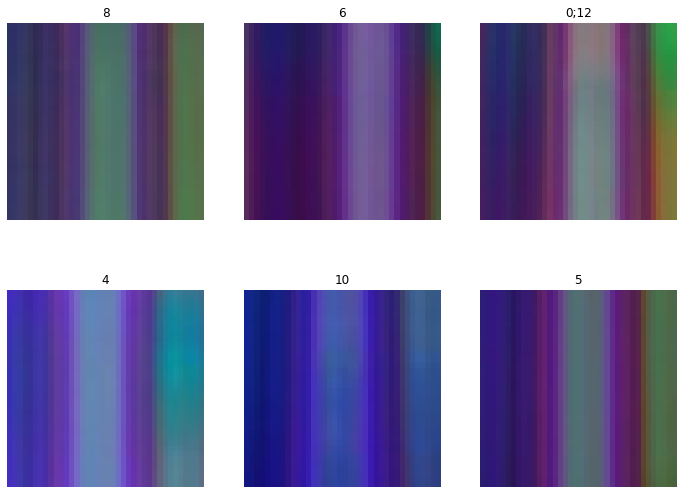

In [9]:
dlsTrain3.show_batch(max_n=9, figsize=(12,9))

In [10]:
learn = cnn_learner(dlsTrain3, resnet50, pretrained=True, metrics=[accuracy_multi])

In [11]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [12]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.002511886414140463)

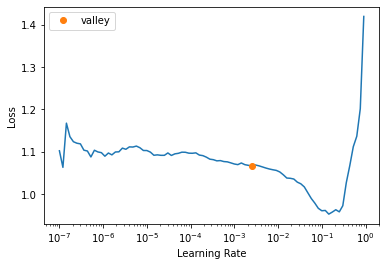

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(50,base_lr=3e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.251061,0.244897,0.915787,04:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.212084,0.164467,0.930668,04:45
1,0.183495,0.155015,0.937674,04:49
2,0.181346,0.143431,0.940826,04:52
3,0.166592,0.143398,0.940698,04:49
4,0.164581,0.141964,0.944278,04:46
5,0.149470,0.131304,0.945263,04:47
6,0.149354,0.127203,0.948401,04:26
7,0.155487,0.127528,0.946533,04:27
8,0.142589,0.122323,0.950927,03:30
9,0.138915,0.121174,0.950627,04:27


In [15]:
learn.save("resnetrsRandAugLS_38frames_multilabel_resnet50")

Path('models/resnetrsRandAugLS_38frames_multilabel_resnet50.pth')

In [16]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [17]:
dbTest = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 get_x = ColReader(0,pref="./dataset_split_38frames/test/",suff='.jpg'),
                 get_y=ColReader(1,label_delim=' '),
                 item_tfms = Resize(50),
                 batch_tfms=[*aug_transforms(size=38, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTest.values,bs=128)



# dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),get_items=get_image_files, 
#                    splitter=GrandparentSplitter(valid_name='test'),get_y=parent_label, 
#                    item_tfms = Resize(512),batch_tfms=[*aug_transforms(size=256, min_scale=0.75), 
#                    Normalize.from_stats(*imagenet_stats)])
# dlsTest = dbTest.dataloaders("./dataset_split_77frames/df_test.csv",bs=32)

In [18]:
learn.dls = dlsTest
learn.validate()

# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

(#2) [0.16554532945156097,0.9525394439697266]

In [19]:
predictions, truth =learn.get_preds()

pred2= []
treshold = 0.5
for predi in predictions:
    adc = []
    for p in predi:
        if p < treshold:
            adc.append(int(0))
        else: adc.append(int(1))
    pred2.append(adc)


In [20]:
print(pred2[5])
print(predictions[5])
print(truth[5])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([2.1619e-04, 1.5574e-04, 2.5744e-01, 2.8036e-01, 1.0204e-01, 3.9687e-04,
        2.0760e-03, 4.7674e-04, 2.6262e-04, 5.9886e-04, 2.5301e-04, 1.1670e-03,
        1.8188e-03])
TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [21]:
from sklearn.metrics import multilabel_confusion_matrix


vis_arr = multilabel_confusion_matrix(truth, pred2)

In [22]:
vis_arr

array([[[2385,   14],
        [  49,   95]],

       [[2424,   19],
        [  36,   64]],

       [[2251,   53],
        [  92,  147]],

       [[2080,   94],
        [ 171,  198]],

       [[2055,  107],
        [ 181,  200]],

       [[2287,   36],
        [  44,  176]],

       [[2301,   17],
        [  53,  172]],

       [[2343,   39],
        [  62,   99]],

       [[2403,   21],
        [  56,   63]],

       [[2408,   16],
        [  49,   70]],

       [[2431,   14],
        [  46,   52]],

       [[2328,   25],
        [  61,  129]],

       [[1806,   84],
        [ 130,  523]]])

In [23]:
labels = ["".join("c" + str(i)) for i in range(0, 13)]


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

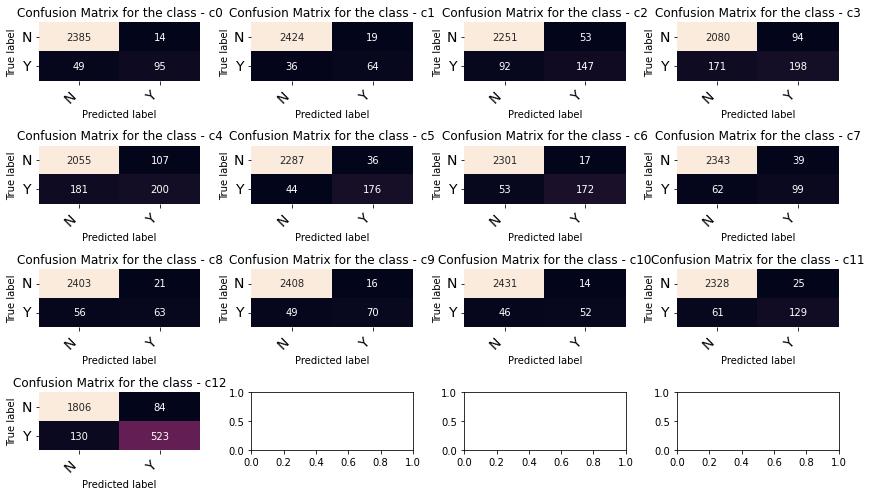

In [25]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [37]:
learn1 = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')]).to_fp16()

In [24]:
# learn1.load("resnetrsRandAugLS")
learn1.load("resnetrsRandAugLS_38frames_multilabel")
# Si lo cargamos así hay que ejecutar también todas las celdas donde se trabajaba con el learner menos el find
# y el entrenamiento

NameError: name 'learn1' is not defined

In [31]:
multilabel_confusion_matrix(truth, pred2)

array([[[1205,    6],
        [  27,   33]],

       [[1212,    7],
        [  22,   30]],

       [[1108,   54],
        [  35,   74]],

       [[1010,   82],
        [  83,   96]],

       [[1038,   42],
        [  93,   98]],

       [[1150,   11],
        [  32,   78]],

       [[1150,   12],
        [  30,   79]],

       [[1162,   22],
        [  27,   60]],

       [[1188,    9],
        [  40,   34]],

       [[1204,    5],
        [  26,   36]],

       [[1203,    6],
        [  31,   31]],

       [[1151,   14],
        [  51,   55]],

       [[ 925,   45],
        [  70,  231]]])